# LECTURE 8 - Data Sourcing with Web Scraping

___

Web Scraping is an alternaive to generate data online in case the website is not offering an API. Instead of analysing a JSON file, web scraping requires us to work with an HTML file.

The goal will be to scrape the [IMD Top 250](https://www.imdb.com/search/title/?groups=top_250&sort=user_rating,desc&view=simple) and answer some questions.


HTML Vocabulary
---

HTML files always follow a cartein structure

```
<p class="important">This is a paragraoh</p>

Tag|attribute|value | content           |tag
```

This can be easily be checkd in the browser if you open the developer tool and go to accessibility where we can find all elemnts, their properties and the path to important.


In [139]:
# We need the request package for handling the API
%matplotlib inline
import numpy as np
import pandas as pd
import requests
import matplotlib

# For the web scraping itself we use BeautifulSoup
from bs4 import BeautifulSoup

In [140]:
# First, let's define the website and thereby dataset we want to work with which is the Top 250 movies rated on IMDb
url = 'https://www.imdb.com/search/title/?groups=top_250&sort=user_rating,desc&view=advanced'

In [141]:
# We force the website with this to send us the data in english when we send the request
headers = {'Accept-Language': 'en-US'}

# We need to call the url
response = requests.get(url, headers=headers)

# We pass the response into a beautiful soup object
soup = BeautifulSoup(response.content, 'html.parser')
soup

3Dft_iba&amp;page-action=ft-iba&amp;ref=ft_iba" target="_blank">Interest-Based Ads<svg class="ipc-link__launch-icon" fill="#000000" height="10" viewbox="0 0 10 10" width="10" xmlns="http://www.w3.org/2000/svg"><g><path d="M9,9 L1,9 L1,1 L4,1 L4,0 L-1.42108547e-14,0 L-1.42108547e-14,10 L10,10 L10,6 L9,6 L9,9 Z M6,0 L6,1 L8,1 L2.998122,6.03786058 L3.998122,7.03786058 L9,2 L9,4 L10,4 L10,0 L6,0 Z"></path></g></svg></a></li><li class="ipc-inline-list__item" role="presentation"><div class="_2mulh8fx3PjJyxvyLovP4w" id="teconsent"></div></li></ul></div></div><div class="imdb-footer__logo _1eKbSAFyeJgUyBUy2VbcS_"><svg aria-label="IMDb, an Amazon company" height="18" title="IMDb, an Amazon company" width="160" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><defs><path d="M26.707 2.45c-3.227 2.374-7.906 3.637-11.935 3.637C9.125 6.087 4.04 4.006.193.542-.11.27.161-.101.523.109 4.675 2.517 9.81 3.968 15.111 3.968c3.577 0 7.51-.74 11.127-2.27.546-.23 1.003.358.47.752z

In [142]:
# Getting the title with BS is very simple where we need to call the string method on the BS object
web_page_title = soup.title.string
web_page_title

'IMDb "Top 250"\n(Sorted by IMDb Rating Descending) - IMDb'

---

## Scraping one Movie

We want to have the title, year and duration of one specific movie

In [143]:
# The find all method finds all elements f a specific kind
movies = soup.find_all('div', class_='lister-item-content')

# Since there more pages, we only get the top 50 movies at once
len(movies)

50

In [144]:
# Let's observe the movie structure
first_movie = movies[0]
first_movie

<div class="lister-item-content">
<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt0111161/">The Shawshank Redemption</a>
<span class="lister-item-year text-muted unbold">(1994)</span>
</h3>
<p class="text-muted">
<span class="certificate">R</span>
<span class="ghost">|</span>
<span class="runtime">142 min</span>
<span class="ghost">|</span>
<span class="genre">
Drama            </span>
</p>
<div class="ratings-bar">
<div class="inline-block ratings-imdb-rating" data-value="9.3" name="ir">
<span class="global-sprite rating-star imdb-rating"></span>
<strong>9.3</strong>
</div>
<div class="inline-block ratings-user-rating">
<span class="userRatingValue" data-tconst="tt0111161" id="urv_tt0111161">
<span class="global-sprite rating-star no-rating"></span>
<span class="rate" data-no-rating="Rate this" data-value="0" name="ur">Rate this</span>
</span>
<div class="starBarWidget" id="sb_tt0111161">
<div class="rating rating-list" d

In [145]:
# Now we filter out the relevant data
first_movie_title = first_movie.find('h3').find('a').string
# WIth the year we need to strip the brackets from the year and take care of some weird structures later on in the document (we only select the last 6 characters -> year and brackets)
first_movie_year = int(first_movie.find('span', class_='lister-item-year').string[-6:].strip('()'))
# With the duration we again need to strip the rest of the integers
first_movie_duration = int(first_movie.find('span', class_='runtime').string.strip(' min'))
# Genre
first_movie_genre = first_movie.find('span', class_='genre').string.strip()
# Rating
first_movie_rating = float(first_movie.find('div', class_='ratings-imdb-rating').find('strong').string)

# Let's print out all of our findings
print(f'Title: {first_movie_title}')
print('\n')
print(f'Year: {first_movie_year}')
print(f'Genre: {first_movie_genre}')
print(f'Duration: {first_movie_duration}')
print(f'Rating: {first_movie_rating}')

Title: The Shawshank Redemption


Year: 1994
Genre: Drama
Duration: 142
Rating: 9.3


---

## Scrape All Top 50 Movies

In ordert o scrape all of the calues, we will need to loop through and also press the 'next page' buttons. On top of that, we will need to save all information into a structure

In [146]:
# This will be our structure for the data
movies_dict = {
    'Title': [],
    'Year': [],
    'Duration': [],
    'Genre': [],
    'Rating': []
}

In [147]:
# Now we loop through the whole first page to get our data, get the corresponding data from each movie and store them in our dict
for movie in movies:
    # Here we get all the data
    movie_title = movie.find('h3').find('a').string
    movie_year = int(movie.find('span', class_='lister-item-year').string[-6:].strip('()'))
    movie_duration = int(movie.find('span', class_='runtime').string.strip(' min'))
    movie_genre = movie.find('span', class_='genre').string.strip()
    movie_rating = float(movie.find('div', class_='ratings-imdb-rating').find('strong').string)

    # Now we need to append each movie to our dictionary
    movies_dict['Title'].append(movie_title)
    movies_dict['Year'].append(movie_year)
    movies_dict['Duration'].append(movie_duration)
    movies_dict['Genre'].append(movie_genre)
    movies_dict['Rating'].append(movie_rating)

In [148]:
movies_dict

{'Title': ['The Shawshank Redemption',
  'The Godfather',
  'The Dark Knight',
  'The Godfather: Part II',
  'The Lord of the Rings: The Return of the King',
  'Pulp Fiction',
  "Schindler's List",
  '12 Angry Men',
  'Hamilton',
  'Inception',
  'Fight Club',
  'The Lord of the Rings: The Fellowship of the Ring',
  'Forrest Gump',
  'The Good, the Bad and the Ugly',
  'The Lord of the Rings: The Two Towers',
  'The Matrix',
  'Goodfellas',
  'Star Wars: Episode V - The Empire Strikes Back',
  "One Flew Over the Cuckoo's Nest",
  'Harakiri',
  'Parasite',
  'Interstellar',
  'City of God',
  'Spirited Away',
  'Saving Private Ryan',
  'The Green Mile',
  'Life Is Beautiful',
  'Se7en',
  'The Silence of the Lambs',
  'Star Wars: Episode IV - A New Hope',
  'Seven Samurai',
  "It's a Wonderful Life",
  'Joker',
  'Whiplash',
  'The Intouchables',
  'The Prestige',
  'The Departed',
  'The Pianist',
  'Gladiator',
  'American History X',
  'The Usual Suspects',
  'Léon: The Professional'

In [149]:
movies_df = pd.DataFrame.from_dict(movies_dict)
movies_df.head(10)

,Title,Year,Duration,Genre,Rating
0,The Shawshank Redemption,1994,142,Drama,9.3
1,The Godfather,1972,175,"Crime, Drama",9.2
2,The Dark Knight,2008,152,"Action, Crime, Drama",9.0
3,The Godfather: Part II,1974,202,"Crime, Drama",9.0
4,The Lord of the Rings: The Return of the King,2003,201,"Action, Adventure, Drama",8.9
5,Pulp Fiction,1994,154,"Crime, Drama",8.9
6,Schindler's List,1993,195,"Biography, Drama, History",8.9
7,12 Angry Men,1957,96,"Crime, Drama",8.9
8,Hamilton,2020,160,"Biography, Drama, History",8.8
9,Inception,2010,148,"Action, Adventure, Sci-Fi",8.8


<AxesSubplot:>

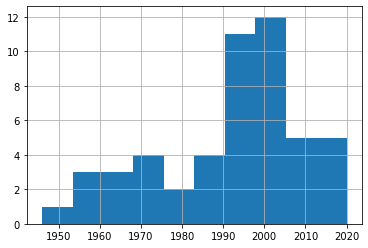

In [150]:
# Now we can play around with the data like this one which shows that a lot of the movies between 1990 and 2010 are in the top 50 than others
movies_df['Year'].hist()

In [151]:
# Getting all movies in the top 50 that are longer than 3
above_3_hours = movies_df['Duration'] >= 6*30
movies_df[above_3_hours]

,Title,Year,Duration,Genre,Rating
3,The Godfather: Part II,1974,202,"Crime, Drama",9.0
4,The Lord of the Rings: The Return of the King,2003,201,"Action, Adventure, Drama",8.9
6,Schindler's List,1993,195,"Biography, Drama, History",8.9
25,The Green Mile,1999,189,"Crime, Drama, Fantasy",8.6
30,Seven Samurai,1954,207,"Action, Adventure, Drama",8.6


---

## Scrpaing All the Top 250 Movies

In order to do that we need to click in between all sites

In [152]:
# This list helps us to loop through the different pages
pages = [0, 51, 101, 151, 201]

# This will be our structure for the data
movies_dict = {
    'Title': [],
    'Year': [],
    'Duration': [],
    'Genre': [],
    'Rating': []
}

# Now we loop through the pages and get and append all the data again
for page in pages:
    # Every time the loop is starting again we need to update the URL to go to the next page
    url = f'https://www.imdb.com/search/title/?groups=top_250&sort=user_rating,desc&start={page}&ref_=adv_prv'

    # We force the website with this to send us the data in english when we send the request
    headers = {'Accept-Language': 'en-US'}
    # We need to call the url
    response = requests.get(url, headers=headers)
    # We pass the response into a beautiful soup object
    soup = BeautifulSoup(response.content, 'html.parser')
    # The find all method finds all elements f a specific kind
    movies = soup.find_all('div', class_='lister-item-content')

    # Now we loop through the whole first page to get our data, get the corresponding data from each movie and store them in our dict
    for movie in movies:
        # Here we get all the data
        movie_title = movie.find('h3').find('a').string
        movie_year = int(movie.find('span', class_='lister-item-year').string[-6:].strip('()'))
        movie_duration = int(movie.find('span', class_='runtime').string.strip(' min'))
        movie_genre = movie.find('span', class_='genre').string.strip()
        movie_rating = float(movie.find('div', class_='ratings-imdb-rating').find('strong').string)

        # Now we need to append each movie to our dictionary
        movies_dict['Title'].append(movie_title)
        movies_dict['Year'].append(movie_year)
        movies_dict['Duration'].append(movie_duration)
        movies_dict['Genre'].append(movie_genre)
        movies_dict['Rating'].append(movie_rating)


In [159]:
# Now that we have the data we create a new dataframe again
all_movies_df = pd.DataFrame.from_dict(movies_dict)
all_movies_df.head(10)

,Title,Year,Duration,Genre,Rating
0,The Shawshank Redemption,1994,142,Drama,9.3
1,The Godfather,1972,175,"Crime, Drama",9.2
2,The Dark Knight,2008,152,"Action, Crime, Drama",9.0
3,The Godfather: Part II,1974,202,"Crime, Drama",9.0
4,The Lord of the Rings: The Return of the King,2003,201,"Action, Adventure, Drama",8.9
5,Pulp Fiction,1994,154,"Crime, Drama",8.9
6,Schindler's List,1993,195,"Biography, Drama, History",8.9
7,12 Angry Men,1957,96,"Crime, Drama",8.9
8,Hamilton,2020,160,"Biography, Drama, History",8.8
9,Inception,2010,148,"Action, Adventure, Sci-Fi",8.8


In [162]:
# Do we have all the movies?
all_movies_df.shape

(250, 5)

<AxesSubplot:>

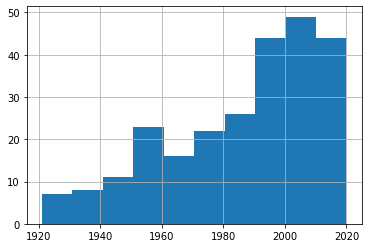

In [164]:
# Let's do the same analysis as before again to see what changes with more movies
all_movies_df['Year'].hist()

In [165]:
# Getting all movies in the top 50 that are longer than 3
above_3_hours = all_movies_df['Duration'] >= 6*30
all_movies_df[above_3_hours]

,Title,Year,Duration,Genre,Rating
3,The Godfather: Part II,1974,202,"Crime, Drama",9.0
4,The Lord of the Rings: The Return of the King,2003,201,"Action, Adventure, Drama",8.9
6,Schindler's List,1993,195,"Biography, Drama, History",8.9
25,The Green Mile,1999,189,"Crime, Drama, Fantasy",8.6
30,Seven Samurai,1954,207,"Action, Adventure, Drama",8.6
57,Avengers: Endgame,2019,181,"Action, Adventure, Drama",8.4
69,Once Upon a Time in America,1984,229,"Crime, Drama",8.4
112,Lawrence of Arabia,1962,228,"Adventure, Biography, Drama",8.3
128,Gangs of Wasseypur,2012,321,"Action, Crime, Drama",8.2
133,The Wolf of Wall Street,2013,180,"Biography, Crime, Drama",8.2


There are a lot of companies like [Dataminer.io](https://data-miner.io/) that make use of web-scraping and offer it as SaaS